## Finding Your Way In The City

In this notebook you'll combine the work of previous exercises to calculate a minimal series of waypoints in order to get from a start location to a goal location.

You'll reuse and modify your algorithms from:

- A*
- Configuration Space
- Collinearity and/or Bresenham

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from grid_A_star_city import create_grid
from planning_A_star_city import a_star

%matplotlib inline

from bresenham import bresenham

In [2]:
plt.rcParams['figure.figsize'] = 12, 12

You'll notice we've imported `create_grid`, and `a_star`. These are functions you've implemented in previous exercises, and here you'll use them to create a map and find a path from a starting position to a goal position.

To read the function signature and documentation execute `?` followed by the function name in a cell. In the example below we'll check the documentation for `create_grid`.

In [3]:
?create_grid

If you would like to alter these implementations, you can modify [grid.py](/edit/grid.py) and [planning.py](/edit/planning.py) in the current directory.

In [4]:
# This is the same obstacle data from the previous lesson.
filename = 'colliders_A_star_city.csv'
data = np.loadtxt(filename, delimiter=',', dtype='Float64', skiprows=2)
print(data)

[[-310.2389   -439.2315     85.5         5.          5.         85.5     ]
 [-300.2389   -439.2315     85.5         5.          5.         85.5     ]
 [-290.2389   -439.2315     85.5         5.          5.         85.5     ]
 ...
 [ 257.8061    425.1645      1.75852     1.292725    1.292725    1.944791]
 [ 293.9967    368.3391      3.557666    1.129456    1.129456    3.667319]
 [ 281.5162    354.4156      4.999351    1.053772    1.053772    4.950246]]


In [5]:
# Static drone altitude (meters)
drone_altitude = 5

# Minimum distance stay away from obstacle (meters)
safe_distance = 3

In [6]:
# TODO: Use `create_grid` to create a grid configuration space of
# the obstacle data.
grid = create_grid(data, drone_altitude, safe_distance)

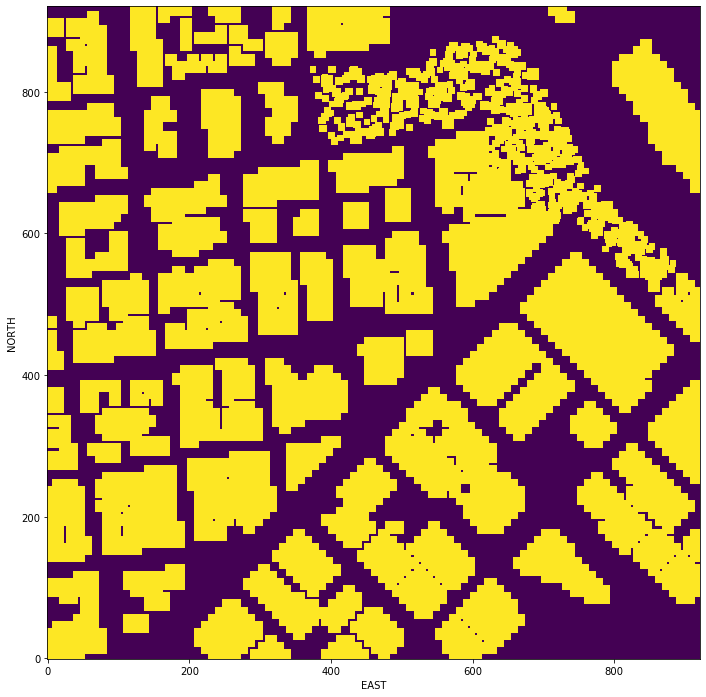

In [7]:
# equivalent to
# plt.imshow(np.flip(grid, 0))
plt.imshow(grid, origin='lower') 

plt.xlabel('EAST')
plt.ylabel('NORTH')
plt.show()

Next you'll compute the path from a start location to a goal location using A*.

Start and goal coordinates in *(north, east)*.

In [8]:
start_ne = (25,  100) # (north, east)
goal_ne = (750., 370.)
#goal_ne = (550, 700)

Write a heuristic function.

In [9]:
def heuristic_func(position, goal_position):
    # TODO: write a heuristic!
    return np.abs(position[0] - goal_position[0]) + np.abs(position[1] - goal_position[1])

# 이전 A*에서 사용했던 휴리스틱 -> 이 휴리스틱을 사용해도 cost값 똑같다.
"""
def heuristic(position, goal_position):
    h = np.sqrt((position[0] - goal_position[0])**2 + (position[1] - goal_position[1])**2)
    return h
"""

'\ndef heuristic(position, goal_position):\n    h = np.sqrt((position[0] - goal_position[0])**2 + (position[1] - goal_position[1])**2)\n    return h\n'

Compute the lowest cost path with `a_star`. 

In [10]:
# TODO: use `a_star` to compute the lowest cost path
path, cost = a_star(grid, heuristic_func, start_ne, goal_ne)
#print(path, cost)
print(len(path))
print(cost)

Found a path.
1024
1023.0


Let's plot the path!

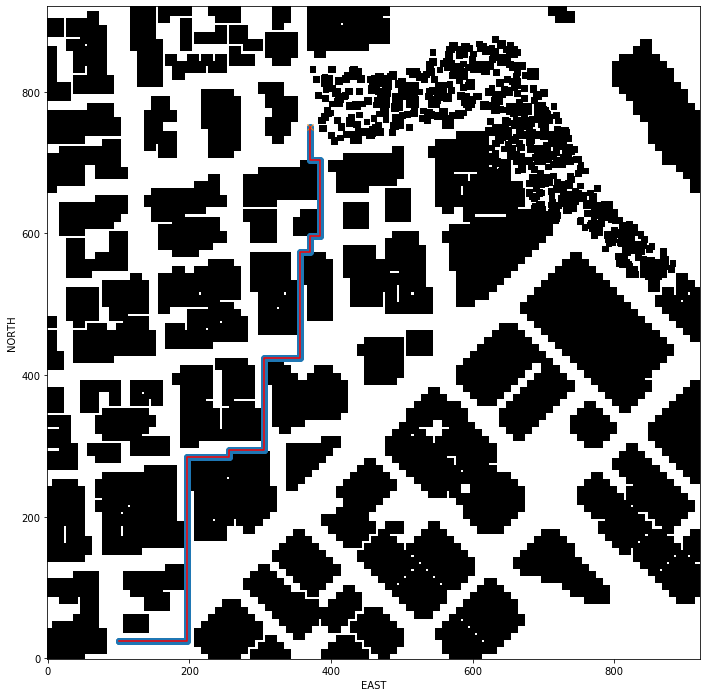

In [11]:
plt.imshow(grid, cmap='Greys', origin='lower')

# For the purposes of the visual the east coordinate lay along
# the x-axis and the north coordinates long the y-axis.
plt.plot(start_ne[1], start_ne[0], 'o')
plt.plot(goal_ne[1], goal_ne[0], 'x')

if path is not None:
    pp = np.array(path)
    plt.plot(pp[:, 1], pp[:, 0], 'r')
    plt.scatter(pp[:, 1], pp[:, 0])

plt.xlabel('EAST')
plt.ylabel('NORTH')
plt.show()

Pretty neat! Unfortunately this path is impractical, the drone would be constantly stopping and going since each grid cell visited is synonymous with a waypoint. Ideally, we'd like to only consider a new waypoint when the drone's direction changes. Path pruning is one way to achieve this result.

### Path Pruning

In [12]:
def point(p):
    return np.array([p[0], p[1], 1.]).reshape(1, -1)

def collinearity_check(p1, p2, p3, epsilon=1e-6):   
    m = np.concatenate((p1, p2, p3), 0)
    det = np.linalg.det(m)
    return abs(det) < epsilon

Complete the `prune_path` function below. It should return a new path much shorter than the original.

In [13]:
def prune_path(path):# waypoint 사용하여 불필요한 point 제거
    if path is not None:
        pruned_path = [p for p in path]
        # TODO: prune the path!
        i = 0
        while i < len(pruned_path) - 2:
            p1 = point(pruned_path[i])
            p2 = point(pruned_path[i+1])
            p3 = point(pruned_path[i+2])

            # If the 3 points are in a line remove
            # the 2nd point.
            # The 3rd point now becomes and 2nd point
            # and the check is redone with a new third point
            # on the next iteration.
            if collinearity_check(p1, p2, p3):# 만약 3점이 한 줄에 있으면 두번째 점(p2) 제거.
                # Something subtle here but we can mutate
                # `pruned_path` freely because the length
                # of the list is check on every iteration.
                pruned_path.remove(pruned_path[i+1])
            else:
                i += 1
            
    else:
        pruned_path = path
        
    return pruned_path

Prune the path.

In [18]:
pruned_path = prune_path(path)
print(len(pruned_path))
print(pruned_path)

15
[(25, 100), (25, 196), (284, 196), (284, 256), (294, 256), (294, 306), (424, 306), (424, 356), (574, 356), (574, 370), (596, 370), (596, 384), (704, 384), (704, 370), (750.0, 370.0)]


In [15]:
pruned_path

[(25, 100),
 (25, 196),
 (284, 196),
 (284, 256),
 (294, 256),
 (294, 306),
 (424, 306),
 (424, 356),
 (574, 356),
 (574, 370),
 (596, 370),
 (596, 384),
 (704, 384),
 (704, 370),
 (750.0, 370.0)]

In [16]:
path

[(25, 100),
 (25, 101),
 (25, 102),
 (25, 103),
 (25, 104),
 (25, 105),
 (25, 106),
 (25, 107),
 (25, 108),
 (25, 109),
 (25, 110),
 (25, 111),
 (25, 112),
 (25, 113),
 (25, 114),
 (25, 115),
 (25, 116),
 (25, 117),
 (25, 118),
 (25, 119),
 (25, 120),
 (25, 121),
 (25, 122),
 (25, 123),
 (25, 124),
 (25, 125),
 (25, 126),
 (25, 127),
 (25, 128),
 (25, 129),
 (25, 130),
 (25, 131),
 (25, 132),
 (25, 133),
 (25, 134),
 (25, 135),
 (25, 136),
 (25, 137),
 (25, 138),
 (25, 139),
 (25, 140),
 (25, 141),
 (25, 142),
 (25, 143),
 (25, 144),
 (25, 145),
 (25, 146),
 (25, 147),
 (25, 148),
 (25, 149),
 (25, 150),
 (25, 151),
 (25, 152),
 (25, 153),
 (25, 154),
 (25, 155),
 (25, 156),
 (25, 157),
 (25, 158),
 (25, 159),
 (25, 160),
 (25, 161),
 (25, 162),
 (25, 163),
 (25, 164),
 (25, 165),
 (25, 166),
 (25, 167),
 (25, 168),
 (25, 169),
 (25, 170),
 (25, 171),
 (25, 172),
 (25, 173),
 (25, 174),
 (25, 175),
 (25, 176),
 (25, 177),
 (25, 178),
 (25, 179),
 (25, 180),
 (25, 181),
 (25, 182),
 (25

Replot the path, it will be the same as before but the drone flight will be much smoother.

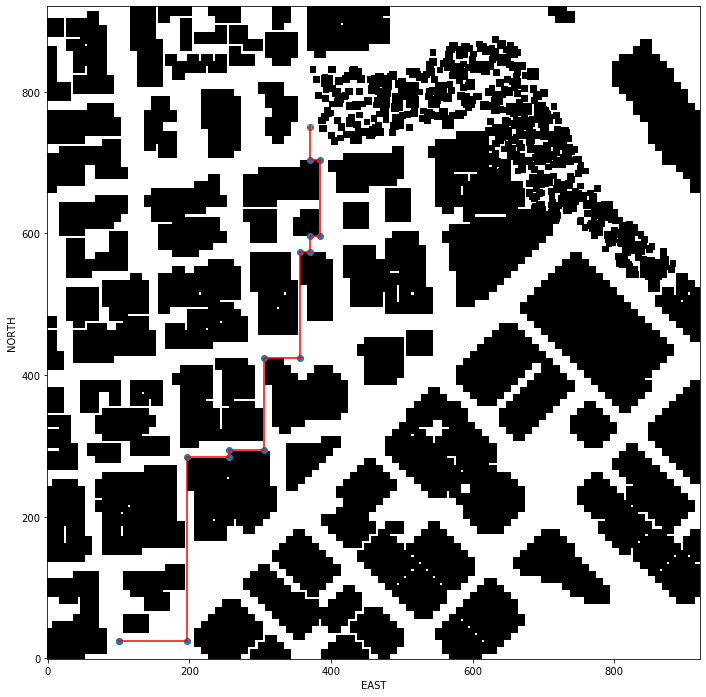

In [17]:
plt.imshow(grid, cmap='Greys', origin='lower')

plt.plot(start_ne[1], start_ne[0], 'o')
plt.plot(goal_ne[1], goal_ne[0], 'x')

if pruned_path is not None:
    pp = np.array(pruned_path)
    plt.plot(pp[:, 1], pp[:, 0], 'r')
    plt.scatter(pp[:, 1], pp[:, 0])

plt.xlabel('EAST')
plt.ylabel('NORTH')

plt.show()

Now the waypoints symbolize a change in direction, much better!

[solution](/notebooks/A-Star-City-Solution.ipynb)